# CIFAR10 first version:

In this notebook im going to make the first model on the CIFAR10 dataset, the model will be build randomly using CNN's and a linear classifer.

## 1. Importing libreries:

In [15]:
import torch 
from torch import nn
from torch.utils.data import DataLoader

import torchvision 
from torchvision import transforms, datasets


## 2. Setting agnostic device

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3. Getting and preparing the Data: 

In [17]:
# Let's make some transformations on the train data to avoid overfitting 
data_augmentation= transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
# We dont need to do the same thing for the test data
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [18]:
# Let's dwonload the data: 

train_data = datasets.CIFAR10(root = "data",
                              train = True,
                              transform = data_augmentation,
                              download = True)
test_data = datasets.CIFAR10(root = "data",
                             train = False,
                             transform = test_transform,
                             download = True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# We need a list of the available classes
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [20]:
from torchvision.transforms.autoaugment import F
# We need to feed the model batches of the train data: 

train_dataloader = DataLoader(train_data,
                              batch_size = 128,
                              shuffle = True,
                              pin_memory=True)
test_dataloader = DataLoader(test_data,
                             batch_size = 128,
                             shuffle = False
                             )

In [21]:
# Now we have an iterable object
images, labels = next(iter(train_dataloader))
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(9))

In [22]:
image, label = train_data[0]
image.shape, label


(torch.Size([3, 32, 32]), 6)

## 4. Building the model:
This model will have two blocks, the feauture extractor and the classifer.

In [23]:
class CIFAR10(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 8, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(8, 32, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32, 32, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3 ,1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, 1, 1),
        nn.ReLU(),
        nn.AvgPool2d(2,2)

    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128*4*4, 10)
    )
  def forward(self, x):
    x = self.classifier(self.feature_extractor(x))
    return x

In [24]:
# Let's take the model to the availble device
model = CIFAR10().to(device)

In [25]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Let's see the informations regarding the architechrure of the model:

In [26]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(128, 3, 32, 32), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CIFAR10 (CIFAR10)                        [128, 3, 32, 32]     [128, 10]            --                   True
├─Sequential (feature_extractor)         [128, 3, 32, 32]     [128, 128, 4, 4]     --                   True
│    └─Conv2d (0)                        [128, 3, 32, 32]     [128, 8, 32, 32]     224                  True
│    └─ReLU (1)                          [128, 8, 32, 32]     [128, 8, 32, 32]     --                   --
│    └─Conv2d (2)                        [128, 8, 32, 32]     [128, 32, 32, 32]    2,336                True
│    └─ReLU (3)                          [128, 32, 32, 32]    [128, 32, 32, 32]    --                   --
│    └─MaxPool2d (4)                     [128, 32, 32, 32]    [128, 32, 16, 16]    --                   --
│    └─Conv2d (5)                        [128, 32, 16, 16]    [128, 32, 16, 16]    9,248                True
│    └─ReLU (6)     

## 5. training:


In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [28]:
from tqdm.auto import tqdm

for epoch in tqdm(range(20)):
  print(f"Epoch number {epoch}")
  train_loss, train_acc = 0, 0
  for batch ,(X,y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    model.train()
    # forward pass 
    pred = model(X)
    # loss 
    loss = loss_fn(pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(pred)
  train_loss = train_loss / len(train_dataloader)
  train_acc = train_acc/len(train_dataloader)
  print(f"EPOCH : {epoch} / train loss :{train_loss} / train accuracy: {train_acc}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch number 0
EPOCH : 0 / train loss :2.011275743889382 / train accuracy: 0.2587795716112532
Epoch number 1
EPOCH : 1 / train loss :1.7662586257280901 / train accuracy: 0.36086157289002563
Epoch number 2
EPOCH : 2 / train loss :1.618044379727005 / train accuracy: 0.41998481457800513
Epoch number 3
EPOCH : 3 / train loss :1.498383432702945 / train accuracy: 0.4628676470588235
Epoch number 4
EPOCH : 4 / train loss :1.3905594696474197 / train accuracy: 0.5045636189258312
Epoch number 5
EPOCH : 5 / train loss :1.3076150697820328 / train accuracy: 0.5357057225063938
Epoch number 6
EPOCH : 6 / train loss :1.243085658611239 / train accuracy: 0.5610493925831203
Epoch number 7
EPOCH : 7 / train loss :1.193642501788371 / train accuracy: 0.5790401214833759
Epoch number 8
EPOCH : 8 / train loss :1.1446144455838996 / train accuracy: 0.5967431265984655
Epoch number 9
EPOCH : 9 / train loss :1.1134129299227233 / train accuracy: 0.6053388746803069
Epoch number 10
EPOCH : 10 / train loss :1.0727995342

## 6. Testing:

In [29]:
model.eval()
test_loss, test_acc  = 0, 0
for X, y in test_dataloader:
  X, y = X.to(device), y.to(device)
  with torch.inference_mode():
    logits = model(X)
    # loss 
    test_loss += loss_fn(logits, y).item()
    pred_class = torch.argmax(logits, dim = 1)
    test_acc += (pred_class == y).sum().item()/len(logits)
test_loss = test_loss/len(test_dataloader)
test_acc = test_acc/len(test_dataloader)
print(f"Test loss: {test_loss}, accuracy: {test_acc}")


Test loss: 0.6587188662607458, accuracy: 0.7734375


## 7. Predictions on the test data:

In [30]:
# make predictions 
import random

samples, labels = [], []
for sample, label in random.sample(list(test_data), k = 10):
  samples.append(sample)
  labels.append(label)
model.eval()
pred_probs = []
for image in samples:
  image = torch.unsqueeze(image, dim = 0).to(device) # we make sure that the shape of the image matches the model 
  preds = model(image)
  pred_prob = torch.softmax(preds.squeeze(), dim = 0 )
  pred_probs.append(pred_prob.cpu())
pred_probs = torch.stack(pred_probs)



  

In [31]:
pred_lables = pred_probs.argmax(dim = 1)
pred_lables, labels

(tensor([5, 0, 8, 1, 9, 4, 1, 1, 3, 6]), [5, 0, 8, 1, 9, 4, 1, 1, 6, 2])

## 8. Ploting the redictions:

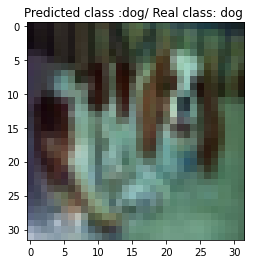

In [32]:
import matplotlib.pyplot as plt 


plt.figure()
for i, sample in enumerate(random.sample(list(samples), k = 10)): 


  plt.imshow(sample.permute(1,2,0))
  plt.title(f"Predicted class :{class_names[pred_probs.argmax(dim=1)[i]]}/ Real class: {class_names[labels[i]]} ")
  break


